# Preamble

In [219]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.animation
from mpl_toolkits import mplot3d
from scipy import optimize
import pandas as pd
import SchemDraw as schem
import SchemDraw.elements as e

# Study case

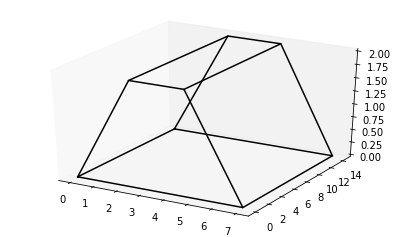

In [158]:
alpha = 40
b = 7
h = 2
l = 100
b2 = h*np.tan(np.deg2rad(90-alpha))

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.grid(False)
def plot_pile(b,b2,h,l,c):
    ax.plot([0,b2,b-b2,b,0],[l/b,l/b,l/b,l/b,l/b],[0,h,h,0,0],c=c)
    ax.plot([0,b2,b-b2,b,0],[0,0,0,0,0],[0,h,h,0,0],c=c)
    ax.plot([0,0],[0,l/b],[0,0],c=c)
    ax.plot([b2,b2],[0,l/b],[h,h],c=c)
    ax.plot([b-b2,b-b2],[0,l/b],[h,h],c=c)
    ax.plot([b,b],[0,l/b],[0,0],c=c)
plot_pile(b,b2,h,l,'k')

In [159]:
def vol(alpha, b, h, l):
    b2 = h*np.tan(np.deg2rad(90-alpha))
    frontArea = h*(b+b2)/2
    totalArea = frontArea*l
    return totalArea

In [160]:
fixedVol = 10000

In [161]:
fVol = lambda l, b, h, alpha, fixedVol : vol(alpha, b, h, l)-fixedVol

In [162]:
optimize.fsolve(fVol, 0, args=(b, h, alpha, fixedVol))

array([1065.69961557])

In [163]:
alphaL = np.linspace(1,89,10)
bL = np.linspace(1,10,10)
hL = np.linspace(1,5,10)

In [164]:
data = np.zeros((len(alphaL)*len(bL)*len(hL),2))
ite = 0
for i in range(len(alphaL)):
    for j in range(len(bL)):
        for k in range(len(hL)):
            L = optimize.fsolve(fVol, 0, args=(bL[j], hL[k], alphaL[i], fixedVol))
            b2 = hL[k]*np.tan(np.deg2rad(90-alphaL[i]))
            side = np.sqrt(b2**2+hL[k]**2)
            data[ite, 0] = bL[j]*L
            data[ite, 1] = 2*(hL[k]*(bL[j]+b2)/2+side*L)+b2*L
            ite += 1

/usr/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


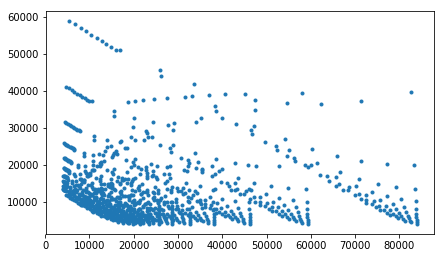

In [165]:
fig, ax = plt.subplots()
plt.plot(4*data[:,0]+data[:,1].min(),data[:,1],'.')

In [166]:
dataSum = 4*data[:,0]+data[:,1].min()+data[:,1]

In [167]:
data[dataSum.argmin(),:]

array([  146.70144719, 11834.61363325])

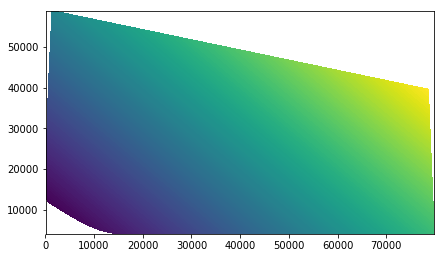

In [168]:
fig, ax = plt.subplots()
plt.tricontourf(4*data[:,0],data[:,1],dataSum,levels=200)

## DATA adquisition

In [169]:
data = np.genfromtxt('global_radiation.txt', delimiter='', skip_header = 14, unpack=True, dtype=float)

mask = np.where(np.logical_and(data[0,:] == 44, data[1,:] == -73))
Solar_radiation = np.zeros(12)
for i in range(2,10):
    Solar_radiation[i] = data[i+2,mask]
Solar_radiation = Solar_radiation[Solar_radiation != 0.]*3600/1000

In [170]:
# Get the values and remove the non valids
dailyWd = np.genfromtxt('weatherData.txt', usecols=(0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19), delimiter=' ')
dailyWd[np.isnan(dailyWd)] = 0

# Preallocation
wD = np.zeros((int(len(dailyWd)/30.),dailyWd.shape[1]))

# Get the monthly mean
for i in range(len(wD)):
    wD[i,:] = np.mean(dailyWd[30*i:30*(i+1),:], axis=0)
    
  # Headers  
# 2017 	Temp. (°C) 	Punto de rocío (°C) 	Humedad (%) 	Sea Level Press. (hPa) 	Visibilidad (km) 	Wind (km/h) 	Precip. (mm) 	Eventos
# Oct 	high 	avg 	low 	high 	avg 	low 	high 	avg 	low 	high 	avg 	low 	high 	avg 	low 	high 	avg 	high 	sum 	 

In [171]:
clouds = 1-np.array([0.51, 0.49, 0.56, 0.59, 0.64, 0.60, 0.54, 0.47, 0.31])

T_sky = np.zeros(8)
e_cloud = np.zeros(8)

for i in range (8):
    e_cloud[i] = (1-.84*clouds[i])*(0.527 + 0.161*np.exp(8.45*(1-(273/(wD[i,2]))))) + 0.84*clouds[i]
    T_sky[i] = ((9.365574e-6)*(1-clouds[i])*(wD[i,2])**6 + e_cloud[i]*clouds[i]*(wD[i,2])**4)**.25

##  Pond values

In [264]:
pond_543 = pd.read_csv("groundData1.csv", squeeze=True, parse_dates=[0], index_col=[0],
                      header = 1, names = ["p50cm", "p1m"])
pond_544 = pd.read_csv("groundData2.csv", squeeze=True, parse_dates=[0], index_col=[0],
                      header = 1, names = ["p5cm", "p20cm"])

In [265]:
# remove NaN and NaT within the columns
pond_543 = pond_543.dropna()
pond_544 = pond_544.dropna()

In [266]:
# remove times without any value within the temperature field
pond_543 = pond_543[pond_543.p50cm != ' ']
pond_544 = pond_544[pond_544.p5cm != ' ']

In [267]:
# convert numeric values to float 
pond_543 = pond_543.astype(float)
pond_544 = pond_544.astype(float)

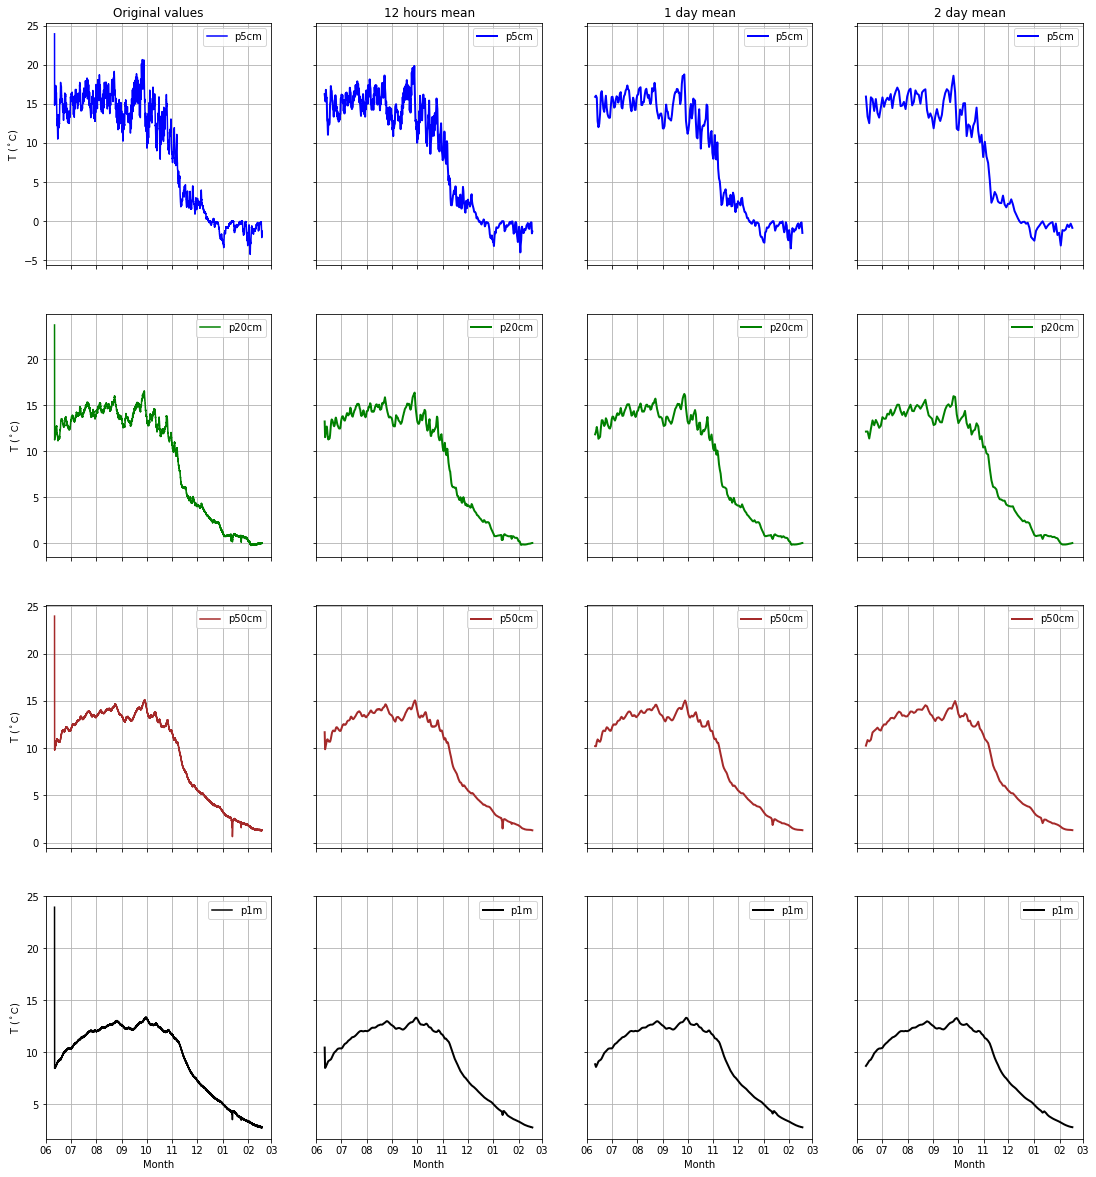

In [268]:
fig, ax = plt.subplots(4,4, sharex=True, sharey='row', figsize=(16,20))
# plot original values
ax[0][0].plot(pond_544.p5cm,'b')
ax[1][0].plot(pond_544.p20cm,'g')
ax[2][0].plot(pond_543.p50cm,'brown')
ax[3][0].plot(pond_543.p1m,'k')
# plot 12 hour means
average = '12H'
ax[0][1].plot(pond_544.resample(average).mean().p5cm,'b', lw=2)
ax[1][1].plot(pond_544.resample(average).mean().p20cm,'g', lw=2)
ax[2][1].plot(pond_543.resample(average).mean().p50cm,'brown', lw=2)
ax[3][1].plot(pond_543.resample(average).mean().p1m,'k', lw=2)
# plot daily means
average = '1D'
ax[0][2].plot(pond_544.resample(average).mean().p5cm, 'b', lw=2)
ax[1][2].plot(pond_544.resample(average).mean().p20cm, 'g', lw=2)
ax[2][2].plot(pond_543.resample(average).mean().p50cm, 'brown', lw=2)
ax[3][2].plot(pond_543.resample(average).mean().p1m, 'k', lw=2)
# plot 2 day means
average = '2D'
ax[0][3].plot(pond_544.resample(average).mean().p5cm, 'b', lw=2)
ax[1][3].plot(pond_544.resample(average).mean().p20cm, 'g', lw=2)
ax[2][3].plot(pond_543.resample(average).mean().p50cm, 'brown', lw=2)
ax[3][3].plot(pond_543.resample(average).mean().p1m, 'k', lw=2)
# plot customization
[ax[-1][i].set_xlim(pd.Timestamp('2017-06-01'),pd.Timestamp('2018-03-01')) for i in range(len(ax))]
[ax[-1][i].xaxis.set_major_locator(mdates.MonthLocator()) for i in range(len(ax))]
[ax[-1][i].xaxis.set_major_formatter(mdates.DateFormatter("%m")) for i in range(len(ax))]
[ax[-1][i].set_xlabel(r"Month") for i in range(len(ax))]
[ax[i][0].set_ylabel(r"$T$ ($^\circ\mathrm{C}$)") for i in range(len(ax))]
[[ax[i][j].legend(loc='upper right', fancybox=True) for i in range(len(ax))] for j in range(len(ax))]
[[ax[i][j].grid(True) for i in range(len(ax))] for j in range(len(ax))];
[ax[0][i].set_title('%s' %['Original values','12 hours mean','1 day mean','2 day mean'][i]) 
 for i in range(len(ax))];

It can be seen that the deeper the probe and the temperatrue readings, the more subtle are the temperature changes, having  a wide spectrum of values in the 5 cm probe and just 'montly' variations in the others without any kind of averaging. In order to obtain a valuable information, a 2 day mean will be used. 

In [276]:
average = '2D'
temp = pd.DataFrame()
temp['_5cm'] = pond_544.resample(average).mean().p5cm
temp['_20cm'] = pond_544.resample(average).mean().p20cm
temp['_50cm'] = pond_543.resample(average).mean().p50cm
temp['_100cm'] = pond_543.resample(average).mean().p1m

Assuming that the conductivity coefficient of the soil is constant for all layers within $0.05 m$ and $1.0 m$, the next step is to compute and plot the different heat transfer values to get drain of heat.

In [277]:
q = pd.DataFrame()
#assuming constant thermal conductivity
k_soil = 0.2 
# compute different heat transfers
q['_20_5_cm'] = -k_soil*(temp._20cm - temp._5cm)/0.15
q['_50_5_cm'] = -k_soil*(temp._50cm - temp._5cm)/0.45
q['_100_5_cm'] = -k_soil*(temp._100cm - temp._5cm)/0.95
q['_50_20_cm'] = -k_soil*(temp._50cm - temp._20cm)/0.30
q['_100_20_cm'] = -k_soil*(temp._100cm - temp._20cm)/0.80
q['_100_50_cm'] = -k_soil*(temp._100cm - temp._50cm)/0.50
# ave_Pond_543['q_20_50'] = -k_soil*(ave_Pond_543.p50cm - ave_Pond_544.p20cm)/0.3
# ave_Pond_543['q_5_20'] = -k_soil*(ave_Pond_544.p20cm - ave_Pond_544.p5cm)/0.15

Text(0.5, 1.0, 'Heat transfer')

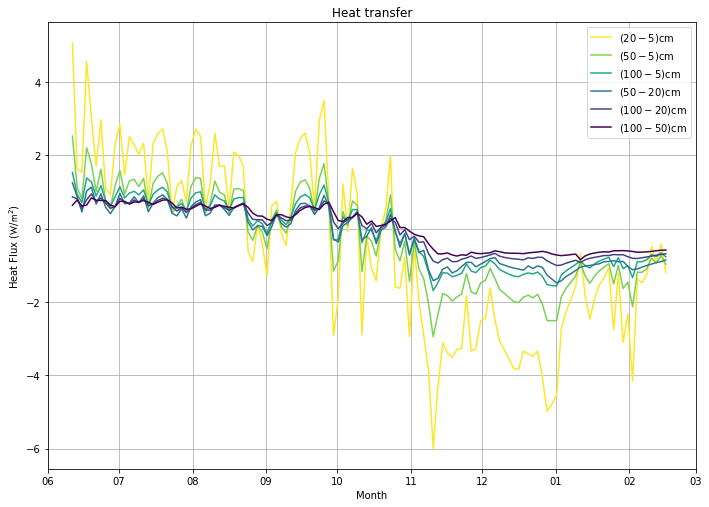

In [327]:
fig, ax = plt.subplots(1, figsize=(10,8))
# plot the heat transfer values
ax.plot(q._20_5_cm,c=plt.cm.viridis(5/5),label=r'$(20-5) cm$')
ax.plot(q._50_5_cm,c=plt.cm.viridis(4/5),label=r'$(50-5) cm$')
ax.plot(q._100_5_cm,c=plt.cm.viridis(3/5),label=r'$(100-5) cm$')
ax.plot(q._50_20_cm,c=plt.cm.viridis(2/5),label=r'$(50-20) cm$')
ax.plot(q._100_20_cm,c=plt.cm.viridis(1/5),label=r'$(100-20) cm$')
ax.plot(q._100_50_cm,c=plt.cm.viridis(0/5),label=r'$(100-50) cm$')
# plot customization
ax.set_xlim(pd.Timestamp('2017-06-01'),pd.Timestamp('2018-03-01')) 
ax.xaxis.set_major_locator(mdates.MonthLocator()) 
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m")) 
ax.set_xlabel(r"Month") 
plt.ylabel(r"Heat Flux ($\mathrm{W}/\mathrm{m}^2)$")
ax.legend(loc='upper right', fancybox=True)
ax.grid(True)
ax.set_title('Heat transfer')

In the above figure can be seen that the use of more stable temperature profiles result in the most stable heat flux profiles, having that the $100-50$ profile gives a very smooth curve, having that also $100-5$ provides a very intersting approach (given that it uses the maximum depth available). What is more interesting and can be seen mor evidently in the next graph is the fact that heat flux sign gets inverted after November has started. This could have been also observed in the temperature figures, where the $100cm$ probe doesn't go much below 5ºC while the 'surface' temperature ($5cm$ probe) goes even below 0ºC.

Text(0.5, 1.0, 'Heat transfer')

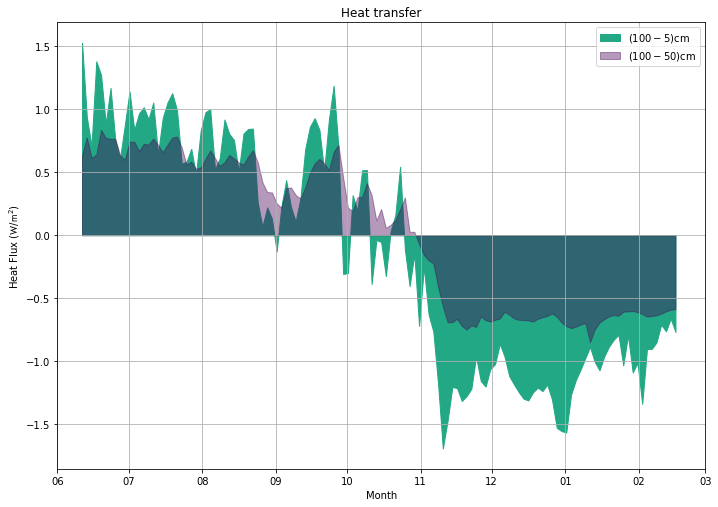

In [332]:
fig, ax = plt.subplots(1, figsize=(10,8))
# plot the heat transfer values
ax.fill_between(temp.index,q._100_5_cm,color=plt.cm.viridis(3/5),label=r'$(100-5) cm$')
ax.fill_between(temp.index,q._100_50_cm,color=plt.cm.viridis(0/5),alpha=0.4,label=r'$(100-50) cm$')
# plot customization
ax.set_xlim(pd.Timestamp('2017-06-01'),pd.Timestamp('2018-03-01')) 
ax.xaxis.set_major_locator(mdates.MonthLocator()) 
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m")) 
ax.set_xlabel(r"Month") 
plt.ylabel(r"Heat Flux ($\mathrm{W}/\mathrm{m}^2)$")
ax.legend(loc='upper right', fancybox=True)
ax.grid(True)
ax.set_title('Heat transfer')

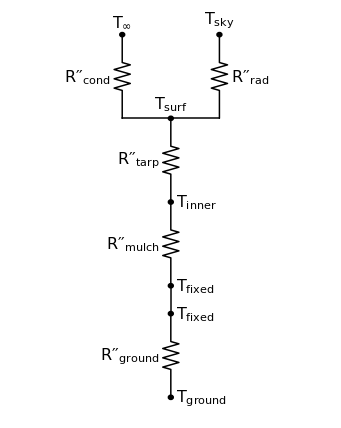

In [178]:
d = schem.Drawing()
# ghost resistance to add some white space below
d.add(e.RES, d = 'right', color = "white")
# back to the heat transfer circuit
d.add(e.DOT, toplabel = r"$T_\infty$")
d.add(e.RES, d = 'down', label = "$R\prime\prime_{cond}$")
d.add(e.LINE, d= 'right', l = 1.5)
d.push()
d.add(e.LINE, d= 'right', l = 1.5)
d.add(e.RES, d = 'up', botlabel = "$R\prime\prime_{rad}$")
d.add(e.DOT, toplabel = r"$T_{sky}$")
# ghost resistance to add some white space below
d.add(e.RES, d = 'right', color = "white")
# back to the heat transfer circuit
d.pop()
d.add(e.DOT, toplabel = r"$T_{surf}$")
d.add(e.RES, d = 'down', label = "$R\prime\prime_{tarp}$")
d.add(e.DOT, rgtlabel = r"$T_{inner}$")
d.add(e.RES, d = 'down', label = "$R\prime\prime_{mulch}$")
d.add(e.DOT, rgtlabel = r"$T_{fixed}$")
d.add(e.LINE, d= 'down', l = 1)
d.add(e.DOT, rgtlabel = r"$T_{fixed}$")
d.add(e.RES, d = 'down', label = "$R\prime\prime_{ground}$")
d.add(e.DOT, rgtlabel = r"$T_{ground}$")
d.draw()